# Time series forecasting (1960 to 1965) - AIr passengers data

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv("F:\Analytics\Learnings\Python\Pratice data\AirPassengers.csv")
df.tail(2)

,Month,#Passengers
142,1960-11,390
143,1960-12,432


In [4]:
df.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [5]:
df.dtypes

Month          object
#Passengers     int64
dtype: object

In [6]:
# Import the datetime library and use 'datetime' function:
from datetime import datetime

# Specificy the index --For analysis we need to used one column
df.index = pd.to_datetime(df.Month) # Pandas to_datetime() method helps to convert string Date time into Python Date time object.
# in above "month" is an object
df.head(2)

,Month,#Passengers
Month,,
1949-01-01,1949-01,112
1949-02-01,1949-02,118


In [7]:
#Data Cleaning
df = df["#Passengers"]['1949-01-01':'1960-12-01']
df.head(2)

Month
1949-01-01    112
1949-02-01    118
Name: #Passengers, dtype: int64

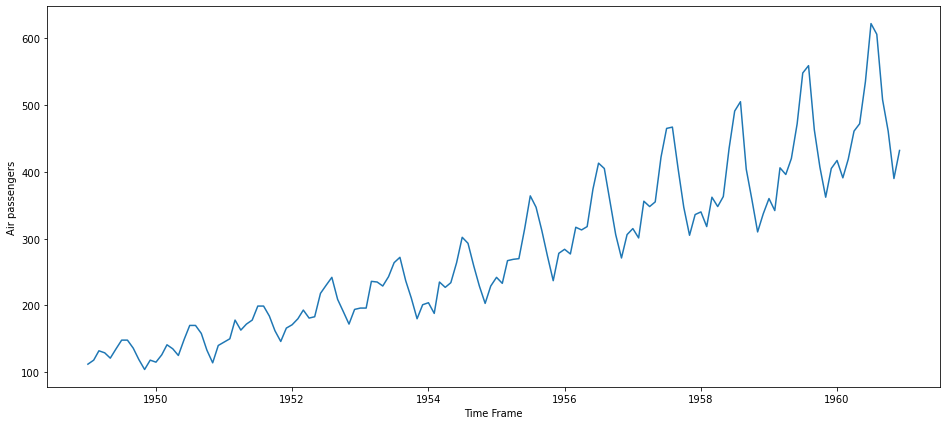

In [8]:
#Data Exploration
plt.figure(figsize=(16,7))
plt.plot(df)
plt.xlabel('Time Frame')
plt.ylabel('Air passengers')
plt.show()

# inference - A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. 
# But why is it important? Most of the TS models work on the assumption that the TS is stationary.


# Checking stationarity

There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

In [9]:
# Method 1 -  Rolling Statistics

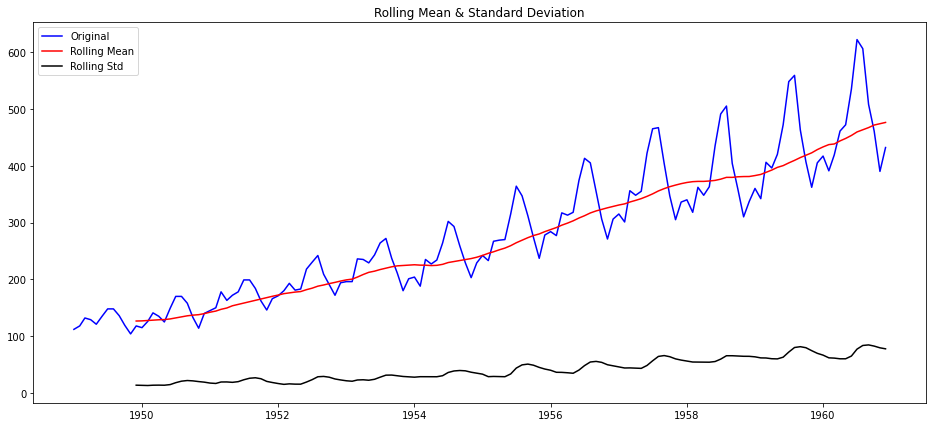

In [10]:
#Determing rolling statistics
rolLmean = df.rolling(12).mean() # 12 means rolling mean of 12 entries
rolLstd = df.rolling(12).std() # 12 means rolling std of 12 entries

plt.figure(figsize=(16,7))

#Plot rolling statistics:
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean') 
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series

# Making Series Stationary

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here.

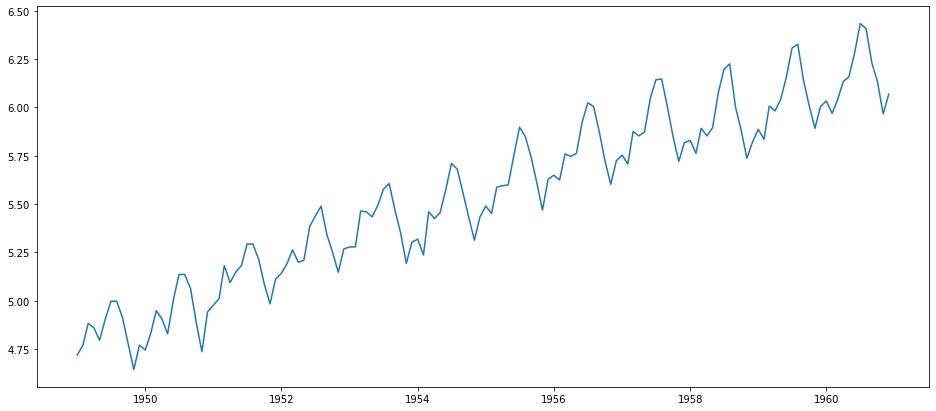

In [11]:
#Lets try transformation
plt.figure(figsize=(16,7))


import numpy as np
ts_log = np.log(df)
plt.plot(ts_log)

In [12]:
ts_log

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Name: #Passengers, Length: 144, dtype: float64

We observe that there is still not stationary. The simple trend reduction techniques like log, sqrt tranaformtion before don’t work in all cases, particularly the ones with high seasonality. So we can go for advanced ways of removing trend and seasonality:
1. Differencing – taking the differece with a particular time lag
2. Decomposition – modeling both trend and seasonality and removing them from the model.

# Eliminating Trend and Seasonality

# A. Decomposing

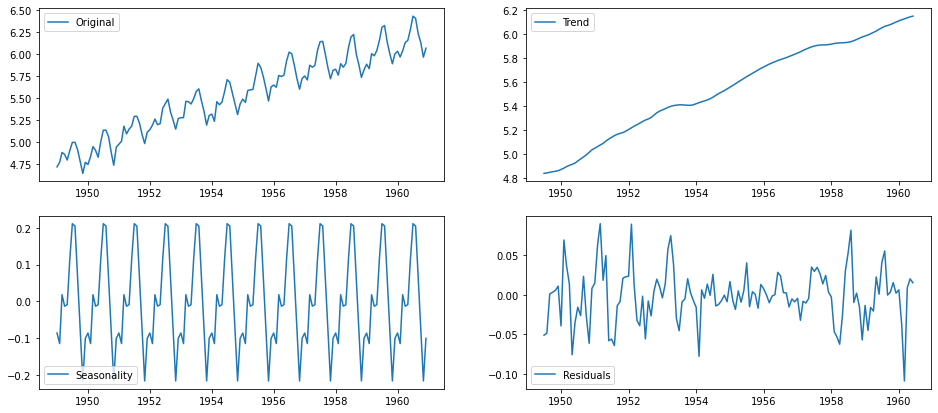

In [13]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))

plt.subplot(2,2,1)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
            
plt.subplot(2,2,3)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
            
plt.subplot(2,2,4)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

# B. Differencing

we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

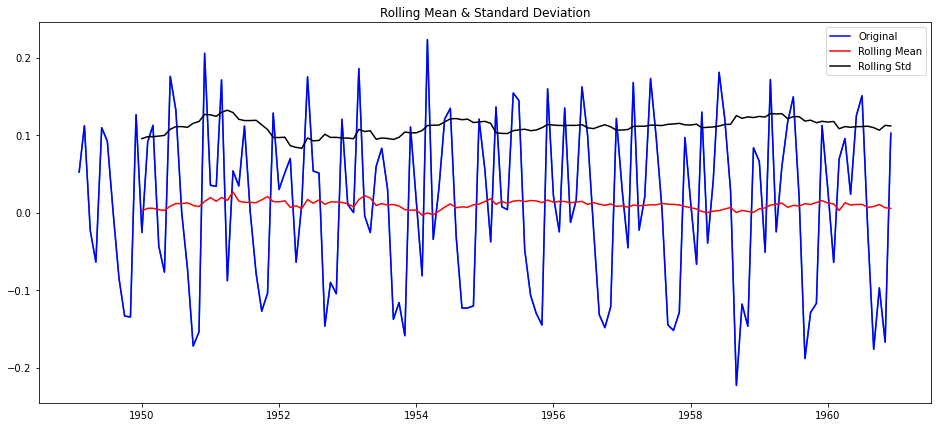

In [14]:
#Lets try differencing
plt.figure(figsize=(16,7))

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()


#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# C. Adfuller test

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
adtest=adfuller(ts_log)
print(" p value is ", adtest[1])

 p value is  0.4223667747703857


# Forecasting a Time Series

Both above techniques performed easonably well for making the TS stationary. Lets make model on the TS after differencing as it is a very popular technique

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5). PACF test is used to find p value ie p is the order of ARA

Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. ACF test is used to find q value ie q is the order of MA
 

Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

In [36]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

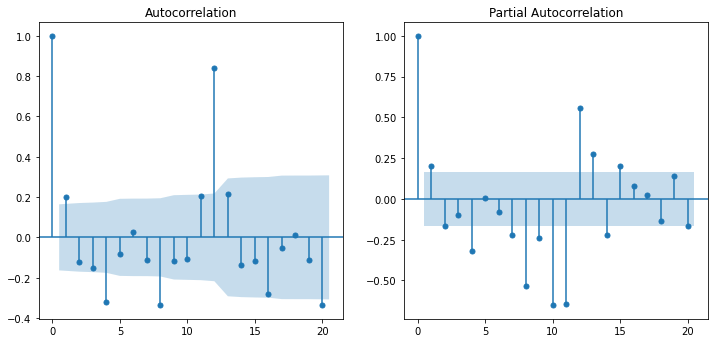

In [18]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,2,1)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=20,ax=ax1)

ax2 = fig.add_subplot(2,2,2)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=20,ax=ax2)

In [19]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


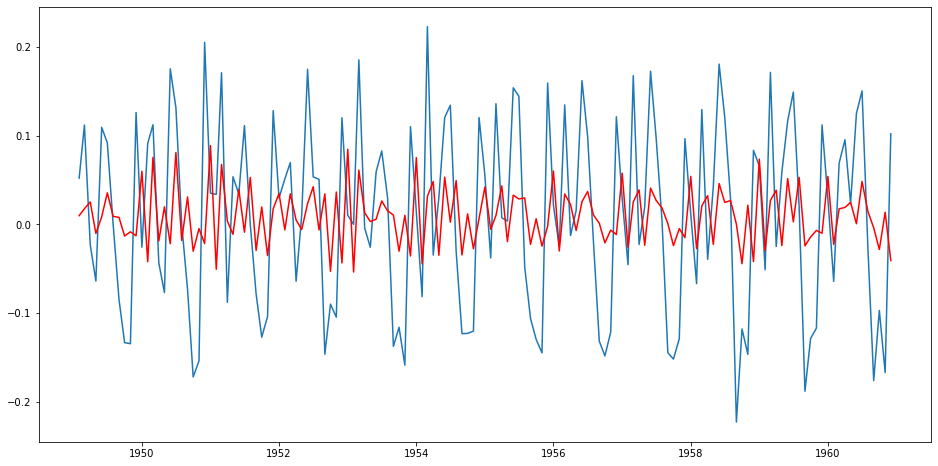

In [20]:
plt.figure(figsize=(16,8))
# ts_log_diff = ts_log_diff[~ts_log_diff.isnull()]

# model fitment
model = ARIMA(ts_log, order=(1,1,1))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff) # actual values
plt.plot(results_ARIMA.fittedvalues, color='red') # fitted values

# Taking it back to original scale

First step would be to store the predicted results as a separate series and observe it.

In [21]:
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())

Month
1949-02-01    0.009800
1949-03-01    0.017618
1949-04-01    0.025229
1949-05-01   -0.010225
1949-06-01    0.008528
dtype: float64


Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [22]:
ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()
print(ARIMA_diff_predictions_cumsum.head())

Month
1949-02-01    0.009800
1949-03-01    0.027418
1949-04-01    0.052648
1949-05-01    0.042422
1949-06-01    0.050950
dtype: float64


Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:

In [23]:
ts_log

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Name: #Passengers, Length: 144, dtype: float64

In [24]:
ts_log.iloc[0]

4.718498871295094

In [25]:
ARIMA_log_prediction = pd.Series(ts_log.iloc[0], index=ts_log.index)
ARIMA_log_prediction 

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
                ...   
1960-08-01    4.718499
1960-09-01    4.718499
1960-10-01    4.718499
1960-11-01    4.718499
1960-12-01    4.718499
Length: 144, dtype: float64

In [26]:
ARIMA_log_prediction = pd.Series(ts_log.iloc[0], index=ts_log.index)
ARIMA_log_prediction = ARIMA_log_prediction.add(ARIMA_diff_predictions_cumsum,fill_value=0)
ARIMA_log_prediction.head()

Month
1949-01-01    4.718499
1949-02-01    4.728299
1949-03-01    4.745917
1949-04-01    4.771146
1949-05-01    4.760921
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

Text(0.5, 1.0, 'RMSE: 52.4891')

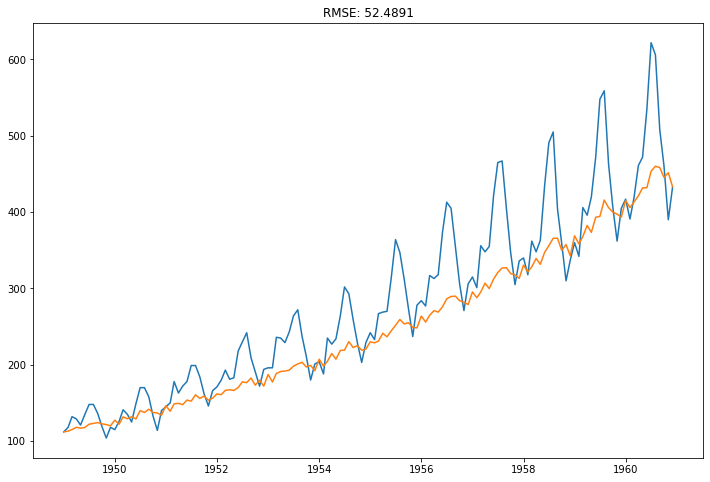

In [27]:
plt.figure(figsize=(12,8))
predictions_ARIMA = np.exp(ARIMA_log_prediction)
plt.plot(df)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df)**2)/len(df)))

In [35]:
results_ARIMA.predict(1,200)

1949-02-01    0.009800
1949-03-01    0.017618
1949-04-01    0.025229
1949-05-01   -0.010225
1949-06-01    0.008528
                ...   
1965-05-01    0.009800
1965-06-01    0.009800
1965-07-01    0.009800
1965-08-01    0.009800
1965-09-01    0.009800
Freq: MS, Length: 200, dtype: float64

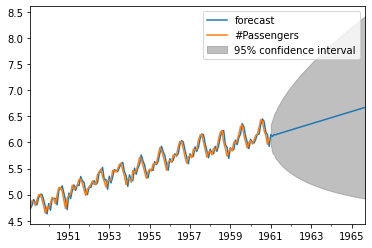

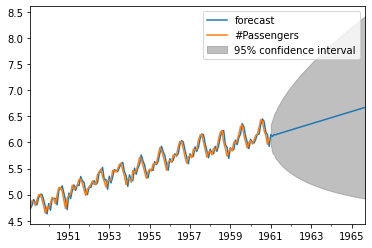

In [29]:
results_ARIMA.plot_predict(1,200)

In [39]:
x=results_ARIMA.forecast(steps=200)
#print(x[1])
#print(len(x[1]))
#print(np.exp(x[1]))

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,6.146037,6.116331,6.149147,6.145538,6.16315,6.168399,6.18085,6.189106,6.199806,6.209081,...,7.983077,7.992877,8.002677,8.012477,8.022277,8.032077,8.041877,8.051677,8.061477,8.071277
1,0.100979,0.163038,0.197948,0.232226,0.259625,0.285681,0.308858,0.33079,0.351149,0.370504,...,1.630896,1.635164,1.63942,1.643665,1.647899,1.652122,1.656334,1.660536,1.664727,1.668908
2,"[5.948123185300376, 6.343951792176463]","[5.796782672340409, 6.4358786726531365]","[5.761176987786376, 6.537117305396947]","[5.6903842394524755, 6.60069155618214]","[5.654295345695953, 6.672004801427654]","[5.608474384683289, 6.728323145010897]","[5.575499980399481, 6.786200727087678]","[5.540769148183333, 6.83744200053963]","[5.511566942088227, 6.888044209733017]","[5.482906431353361, 6.9352560918899355]",...,"[4.7865786525969085, 11.179574856379748]","[4.7880151855990345, 11.197738350714808]","[4.789473487398684, 11.215880076252343]","[4.7909533888935245, 11.234000202094691]","[4.792454723159292, 11.25209889516611]","[4.793977325410715, 11.270176320251874]","[4.795521032963345, 11.288232640036432]","[4.7970856851962385, 11.306268015140725]","[4.798671123515507, 11.324282604158643]","[4.800277191318681, 11.342276563692657]"
